In [56]:
import io
import os
import json
from google.protobuf.json_format import MessageToJson
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from google.cloud import vision
from google.cloud.vision import types

In [3]:
client = vision.ImageAnnotatorClient()

In [5]:
with io.open('./image_files/IMG_2053.jpg', 'rb') as image_file:
    content = image_file.read()

In [6]:
image = types.Image(content=content)

In [55]:
results = client.text_detection(image=image)
serialized = json.loads(MessageToJson(results))


In [73]:
blocks = serialized['fullTextAnnotation']['pages'][0]['blocks']
print(serialized['textAnnotations'])


# text_boxes = []
# for block in blocks:
 
#   text_box = {'text': '', 'boundingBox':[]}
#   for vertex in block['boundingBox']['vertices']:
#     curr_tuple = [vertex['x'], vertex['y']]
#     text_box['boundingBox'].append(curr_tuple)
#   words = block['paragraphs'][0]['words']
#   for word in words:
#     symbols = word['symbols']
#     for symbol in symbols:
#       # print(symbol)
#       text_box['text'] += symbol['text']
#       try: 
#         if symbol['property']['detectedBreak']:
#           text_box['text'] += ' '
#       except:
#         continue

#   text_boxes.append(text_box)

# print(text_boxes)

[{'locale': 'en', 'description': "2\nOGERT GALDINI PRE-SUASION\nDANIEL\nKAHNEMAN\nFASTSLOW\nTHE ELEMENTS oF STYLE\n927 DAYS of SUMMER\nTREE\na life tery\nChuck Klosterman\nBut what If we're wrong?\nTRIBE OF MENTORS TIMOTHY FERRISS\n", 'boundingPoly': {'vertices': [{'x': 525, 'y': 371}, {'x': 2748, 'y': 371}, {'x': 2748, 'y': 2202}, {'x': 525, 'y': 2202}]}}, {'description': '2', 'boundingPoly': {'vertices': [{'x': 2747, 'y': 1402}, {'x': 2747, 'y': 1439}, {'x': 2734, 'y': 1439}, {'x': 2734, 'y': 1402}]}}, {'description': 'OGERT', 'boundingPoly': {'vertices': [{'x': 1992, 'y': 627}, {'x': 2080, 'y': 816}, {'x': 1865, 'y': 917}, {'x': 1776, 'y': 728}]}}, {'description': 'GALDINI', 'boundingPoly': {'vertices': [{'x': 2095, 'y': 852}, {'x': 2248, 'y': 1180}, {'x': 2032, 'y': 1281}, {'x': 1879, 'y': 953}]}}, {'description': 'PRE-SUASION', 'boundingPoly': {'vertices': [{'x': 2283, 'y': 1255}, {'x': 2637, 'y': 2014}, {'x': 2421, 'y': 2115}, {'x': 2067, 'y': 1356}]}}, {'description': 'DANIEL', 

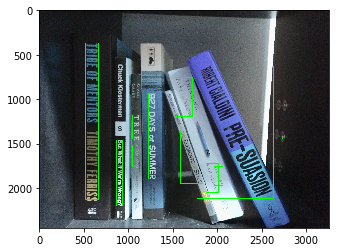

In [72]:
img = cv2.imread('./image_files/IMG_2053.jpg')
for text in text_boxes:
    bounds = text['boundingBox']
    pts = np.array(bounds, np.int32)
    pts = pts.reshape((-1,1,2))
    img = cv2.polylines(img,[pts],True,(0,255,0),3)
plt.imshow(img)